# CIS 400 Project Part 5

Pre-processing （This section do NOT need to rerun）

In [1]:
# requires tensorflow=2.3.0
from transformers import pipeline

In [5]:
sentiment_analysis = pipeline("sentiment-analysis")

All model checkpoint layers were used when initializing TFDistilBertForSequenceClassification.

All the layers of TFDistilBertForSequenceClassification were initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [6]:
# tweets: {'TweetID': ['UserID', 'Source','Text', 'CreatedDate']}
tweets = load_data("tweetinfo.csv")

In [10]:
tweets_sentence = [tweets[k][2] for k in tweets.keys()]

In [20]:
# sentiment analysis
def senti_analysis(tweets, batch = 1000):
    result = []
    size = len(tweets)
    for i in range(0, size, batch):
        x = i
        result += sentiment_analysis(tweets[x:x+batch])
        print("finished:", i+batch)
    return result

In [21]:
#starting at 11:35 am
tweets_sentiments = senti_analysis(tweets_sentence)

finished: 1000
...


finished: 3285000


In [22]:
# attach sentiments to tweets
def attach_sentiments(tweets, sentiments):
    i = 0
    result = tweets
    for k in tweets.keys():
        result[k].append(sentiments[i])
        i += 1
    return result

In [23]:
tweets_new = attach_sentiments(tweets, tweets_sentiments)

In [27]:
save_data(tweets_new, "tweetsentiments.csv")

writing finish


Section 1 -- Load Data

In [3]:
import csv

In [4]:
# read data
def load_data(filename):
    result = {}
    with open(filename, newline='', encoding="utf8") as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
        for row in spamreader:
            result[row[0]] = row[1:]
    return result

In [5]:
# Save data into csv files
def save_data(dic, filename):
    with open(filename,'w', newline='', encoding="utf8") as csvfile:
        csvwriter = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
        for k in dic.keys():
            csvwriter.writerow([k] + dic[k])
        print('writing finish')

In [6]:
# tweets_sentiments: {'TweetID': ['UserID', 'Source','Text', 'CreatedDate', 'Sentiments']}
tweets_sentiments = load_data("tweetsentiments.csv")

# tweets_emotions_NLTK: {'TweetID': ['emotion_score']}
tweets_emotions_NLTK = load_data("tweetemotion.csv")

# users: {'UserID': ['UserName','followers_count', 'friends_count', 'FriendID']}
users = load_data("userinfo.csv")

Section 2 -- Comparsion of Sentiment Algorithms

In [91]:
# Here we compare results between scoring method and pre-trained neural network classification models on sentiment analysis

In [15]:
import matplotlib.pyplot as plt

In [25]:
# Plot distributions
def plot_distribution(points, title_and_xylabels, save_filename, bin_size = 21):
    plt.figure(figsize=(10,8))
    plt.hist(points, bins = bin_size, range = (-1.05,1.05))

    plt.xlabel(title_and_xylabels[1])
    plt.ylabel(title_and_xylabels[2])
    plt.title(title_and_xylabels[0])
    plt.savefig(save_filename)
    plt.show()

In [26]:
# prepare sentiments collected by DistilBERT (NeruIPS '19)
def distilBERT_sentiments(tweets_sentiments):
    result = {}
    for k in tweets_sentiments.keys():
        dict_sentiment = eval(tweets_sentiments[k][4])
        if dict_sentiment['label'] == 'NEGATIVE':
            result[k] = -dict_sentiment['score']
        else:
            result[k] = dict_sentiment['score']
    return result

In [27]:
emotions_NLTK = [float(v[0]) for v in tweets_emotions_NLTK.values()]

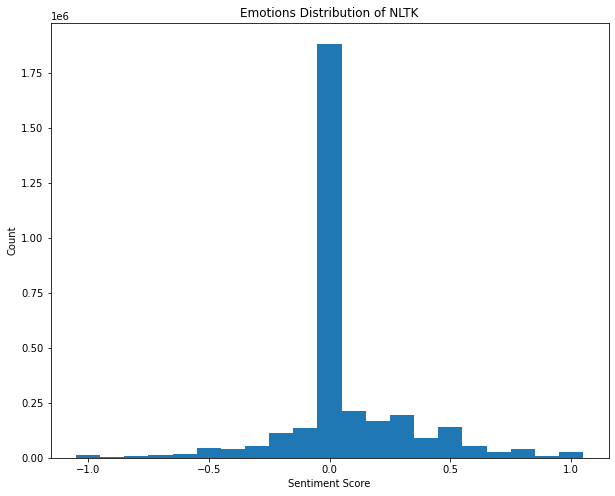

In [10]:
plot_distribution(emotions_NLTK, 
                  ['Emotions Distribution of NLTK', 'Sentiment Score', 'Count'], 
                  'emotions_NLTK_distribution.png')

# Most of tweets have 0 sentiment scores!!
# It is hard to study correlation between sentiments and other features.

In [28]:
sentiments_distilBERT = distilBERT_sentiments(tweets_sentiments)
sentiments_distilBERT # sentiments_distilBERT: {'TweetID': ['Emotional Value']}

{'105': -0.9970303177833557,
... '1104': 0.9962140321731567,
 ...}

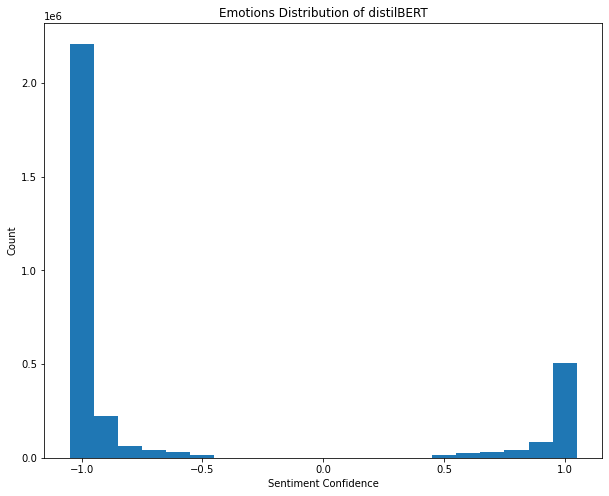

In [12]:
plot_distribution(sentiments_distilBERT.values(), 
                  ['Emotions Distribution of distilBERT', 'Sentiment Confidence', 'Count'], 
                  'emotions_distilBERT_distribution.png')

# Most tweets are classified into either 'positive' or 'negative' with high confidence
# Note that these two are actually completely different methods (Scoring and Classification), 
# binary clasification methods are more suitable for our future tasks rather than scoreing methods. 

In [13]:
# Here we show some actual examples of two methods, how distilBERT is more advanced
print('---------------------example 1---------------------')
print('tweet:', tweets_sentiments['105'][2])
print('NLTK_score:', tweets_emotions_NLTK['105'][0])
print('distilBERT_Result:', tweets_sentiments['105'][4])

print('\n---------------------example 2---------------------')
print('tweet:', tweets_sentiments['106'][2])
print('NLTK_score:', tweets_emotions_NLTK['106'][0])
print('distilBERT_Result:', tweets_sentiments['106'][4])

print('\n---------------------example 3---------------------')
print('tweet:', tweets_sentiments['115'][2])
print('NLTK_score:', tweets_emotions_NLTK['115'][0])
print('distilBERT_Result:', tweets_sentiments['115'][4])

---------------------example 1---------------------
tweet: RT @normanswan: Israel has just done a deal with Moderna for a variant specific vaccine. Why haven’t we?
NLTK_score: 0.0
distilBERT_Result: {'label': 'NEGATIVE', 'score': 0.9970303177833557}

---------------------example 2---------------------
tweet: RT @sanchezcastejon: Spain is commited to equal and universal access to vaccines, @selenagomez. Just this week, I have announced that we wi…
NLTK_score: 0.0
distilBERT_Result: {'label': 'POSITIVE', 'score': 0.9727376699447632}

---------------------example 3---------------------
tweet: RT @AskAnshul: A lobby is urging to import Pfizer vaccine since January. They just want India to buy Pfizer. They don't care about its cost…
NLTK_score: 0.0
distilBERT_Result: {'label': 'NEGATIVE', 'score': 0.998418927192688}


Section 3 -- Sentiments over Time

In [14]:
# plot sentments overtime
# Here we set a threshold to consider confidence score <= 0.95 as Neutal tweets
import datetime as dt

In [15]:
def judge_sentiment(score):
    if score > 0.95:
        return 'Positive'
    elif score < -0.95:
        return 'Negative'
    else:
        return 'Neutral'

def count_sentiment(tweets_sentiments, sentiments_distilBERT):
    result = {}
    for k in tweets_sentiments.keys():
        d_t = dt.datetime.strptime(tweets_sentiments[k][3], '%Y-%m-%d %H:%M:%S')
        day = d_t.date()
        score = sentiments_distilBERT[k]
        if day not in result.keys():
            result[day] = {'Positive': 0, 'Negative': 0 ,'Neutral':0}
            
        result[day][judge_sentiment(score)] += 1
            
    return result

In [16]:
def plot_sentiment(data, title_and_xylabels, save_filename):
    date = []
    negative = []
    positive = []
    
    start_date = dt.date(2019, 4, 26)
    end_date = dt.date(2021, 4, 26)
    delta = dt.timedelta(days = 1)
    while start_date <= end_date:
        date.append(start_date)
        if start_date in data.keys():
            da = data[start_date]
            total = da['Positive'] + da['Negative'] + da['Neutral']
            positive.append(da['Positive']/total)
            negative.append(-da['Negative']/total)
        else:
            positive.append(0)
            negative.append(0)
        start_date += delta 
    
    fig = plt.figure(figsize=(25,8))
    plt.xlabel(title_and_xylabels[1])
    plt.ylabel(title_and_xylabels[2])
    plt.title(title_and_xylabels[0])
    plt.axvline(x = dt.date(2020,3,1), color = 'y', linewidth=10, alpha=0.7)
    plt.plot([dt.date(2020,3,1), dt.date(2021,4,26)], [-0.64, -0.7], color = 'y', linewidth=10, alpha=0.7)
    plt.plot([dt.date(2020,3,1), dt.date(2021,4,26)], [0.18, 0.12], color = 'y', linewidth=10, alpha=0.7)
    ax = plt.subplot(111)
    ax.bar(date, negative, width=1, color='b', alpha=0.9)
    ax.bar(date, positive, width=1, color='r', alpha=0.9)
    
    fig.savefig(save_filename)
    plt.show()

In [17]:
senti_over_time = count_sentiment(tweets_sentiments, sentiments_distilBERT)

<ipython-input-16-bb46b30f4964>:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(111)


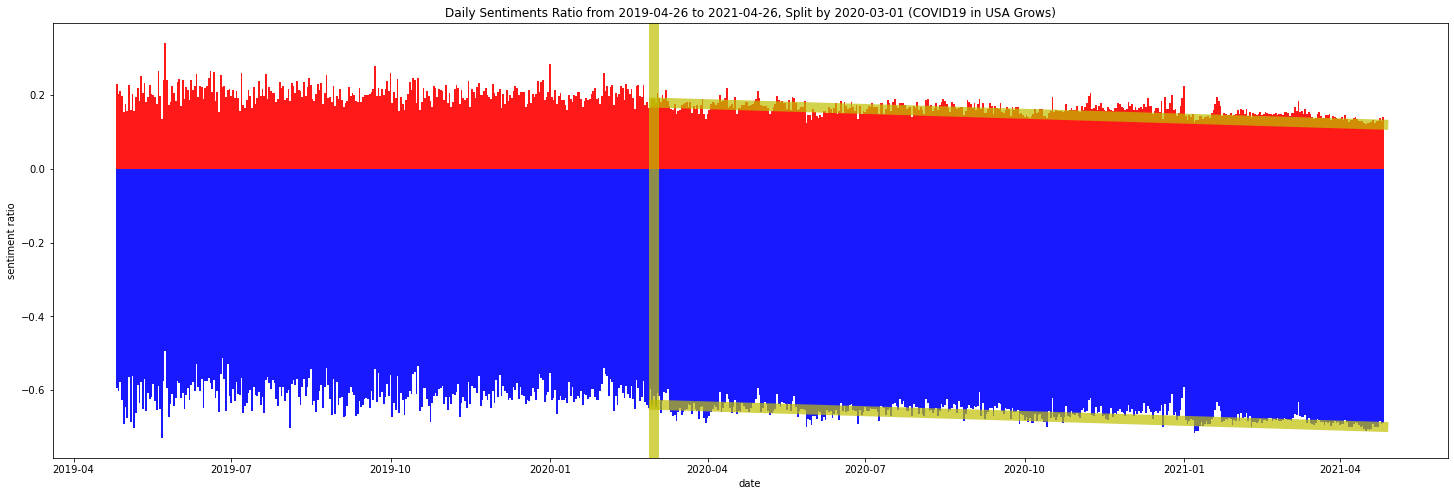

In [18]:
plot_sentiment(senti_over_time, 
               ['Daily Sentiments Ratio from 2019-04-26 to 2021-04-26, Split by 2020-03-01 (COVID19 in USA Grows)', 'date', 'sentiment ratio'], 
               'sentiments over time.png')

In [ ]:
# Here we conclude:
# 1. people on twitter are mostly negative (roughly 20% positve/ 60% negative)

# 2. before the pandemic people's sentiments are relatively stable

# 3. through the pandemic people's sentiments become more and more negative 
# (This can be shown by simple linear regression, we will include it in report)

Section 4 -- Sentiments vs. Popularity over COVID19 pandemic

In [184]:
# Here we discuss whether sentiments are related with user's popularities (followers/friends)
# We use K-means of euclidean distance to clustering users 
# However, K-means is super sensitive to distances, we log our followers/friends count to mitigate this

In [7]:
from sklearn.cluster import KMeans
import numpy as np
import math

In [8]:
# transfer to 2-dimensional points after log followers/friendes
def prepare_points(user_data):
    result = {}
    for k in user_data.keys():
        result[k] = (math.log10(int(user_data[k][1]) + 1), math.log10(int(user_data[k][2]) + 1))
    return result

In [9]:
# elbow method to select k 
# We measure Within Cluster Sum of Squares (WCSS) for different k, then select a k at 'elbow' of plot
def elbow_k_selecting(points):
    X = np.array(list(points.values()))
    
    wcss = []
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)
    plt.plot(range(1, 11), wcss)
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.savefig('elbow k means.png')
    plt.show()

In [10]:
# K-mean clustering 
def preform_Kmeans(points, k = 4):
    results = {}
    
    X = np.array(list(points.values()))
    kmeans = KMeans(n_clusters = k, random_state = 0).fit(X)
    labels = kmeans.labels_
    userids = list(points.keys())
    for i in range(len(userids)):
        results[userids[i]] = labels[i]
    
    return kmeans.cluster_centers_, results

In [11]:
# sentiments of different groups during COVID19 pandemic(from 2020-03-01)
def sentiments_towards_popularity(tweets_sentiments, sentiments_distilBERT, user_clusters):
    result = {'Positive':[0,0,0,0], 'Negative':[0,0,0,0], 'Neutral':[0,0,0,0]}
    
    for k in tweets_sentiments.keys():
        d_t = dt.datetime.strptime(tweets_sentiments[k][3], '%Y-%m-%d %H:%M:%S')
        day = d_t.date()
        if day >= dt.date(2020, 3, 1):
            user_id = tweets_sentiments[k][0]
            group_id = user_clusters[user_id]
            sentiment = judge_sentiment(sentiments_distilBERT[k])
            result[sentiment][group_id] += 1
    return result

In [12]:
# plot sentiments over group
def plot_sentiment_group(sentiments_over_group):
    group_total = [0]*4
    for i in range(4):
        group_total[i] = sentiments_over_group['Negative'][i]+sentiments_over_group['Positive'][i]+sentiments_over_group['Neutral'][i]
    
    N = 4
    positive = (sentiments_over_group['Positive'][2]/group_total[2], sentiments_over_group['Positive'][0]/group_total[0], 
               sentiments_over_group['Positive'][1]/group_total[1], sentiments_over_group['Positive'][3]/group_total[3])
    neutral = (sentiments_over_group['Neutral'][2]/group_total[2], sentiments_over_group['Neutral'][0]/group_total[0], 
               sentiments_over_group['Neutral'][1]/group_total[1], sentiments_over_group['Neutral'][3]/group_total[3])
    negative = (sentiments_over_group['Negative'][2]/group_total[2], sentiments_over_group['Negative'][0]/group_total[0], 
               sentiments_over_group['Negative'][1]/group_total[1], sentiments_over_group['Negative'][3]/group_total[3])
    

    ind = np.arange(N) 
    width = 0.25       
    plt.bar(ind, positive, width, label='Positive', color = 'r')
    plt.bar(ind + width, neutral, width, label='Neutral', color = 'y')
    plt.bar(ind + 2*width, negative, width, label='Negative', color = 'b')

    plt.ylim((0,1))
    plt.ylabel('Ratio')
    plt.xlabel('Popularity')
    plt.title('Sentiments over User Popularity')

    plt.xticks(ind + width, ('Low', 'Medium', 'High', 'ExtremeHigh'))
    plt.legend(loc='best')
    plt.savefig("sentiment_over_popularity.png")
    plt.show()

In [13]:
user_points = prepare_points(users) #user_points: {'UserID': ['followers_count', 'friends_count']}

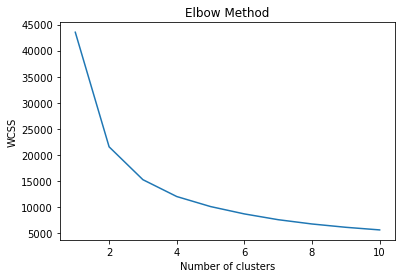

In [16]:
elbow_k_selecting(user_points)
# from this plot we select k=4

In [17]:
centers, user_clusters = preform_Kmeans(user_points)

In [22]:
# these are centers of each clusters
# We name these clusters by:
# 0 -- medium popularity group
# 1 -- high popularity group
# 2 -- low popularity group
# 3 -- extremely high popularity group
print(centers)

[[3.3805696  3.35221047]
 [1.78778208 2.22947507]
 [2.63955523 2.79421643]
 [4.59599319 3.35030803]]


In [222]:
sentiments_over_group = sentiments_towards_popularity(tweets_sentiments, sentiments_distilBERT, user_clusters)

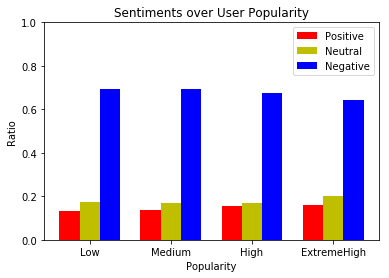

In [245]:
plot_sentiment_group(sentiments_over_group)

In [ ]:
# Here we conclude accounts with higher popularity are slightly more positive
# Maybe because all official accounts are in 'ExtremeHigh' group